In [19]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

tf.config.set_visible_devices([], 'GPU') #disables GPU


In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg




In [21]:
# load dataset
dataset = read_csv('../semi_filled', header=0, index_col=0)
values = dataset.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[range(len(dataset.columns), len(dataset.columns)*2)], axis=1, inplace=True)

reframed.describe()

AttributeError: 'numpy.ndarray' object has no attribute 'describe'

In [16]:
import numpy as np
def create_sequences(data, seq_length):
    x = []
    y = []
    for i in range(len(data) - seq_length - 1):
        x.append(data[i:i+seq_length, 1:])  # Exclude BC concentration from input features
        y.append(data[i:i+seq_length, 0])  # BC concentration as the target variable
    return np.array(x), np.array(y)

seq_length = 24*2
x, y = create_sequences(scaled, seq_length)


In [17]:

# Split the dataset into training and validation sets
train_size = 24*25
x_train, x_val = x[:train_size], x[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

In [18]:
# split into train and test sets
values = reframed.values
n_train_hours = 170 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)



(3959, 1, 12) (3959,) (0, 1, 12) (0,)


In [7]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2,
                    shuffle=False)

Epoch 1/50


2023-06-05 10:46:00.735530: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


57/57 - 1s - loss: 0.1168 - val_loss: 0.0644 - 975ms/epoch - 17ms/step
Epoch 2/50
57/57 - 0s - loss: 0.0513 - val_loss: 0.0565 - 72ms/epoch - 1ms/step
Epoch 3/50
57/57 - 0s - loss: 0.0441 - val_loss: 0.0503 - 63ms/epoch - 1ms/step
Epoch 4/50
57/57 - 0s - loss: 0.0395 - val_loss: 0.0461 - 59ms/epoch - 1ms/step
Epoch 5/50
57/57 - 0s - loss: 0.0368 - val_loss: 0.0431 - 57ms/epoch - 1ms/step
Epoch 6/50
57/57 - 0s - loss: 0.0350 - val_loss: 0.0408 - 60ms/epoch - 1ms/step
Epoch 7/50
57/57 - 0s - loss: 0.0336 - val_loss: 0.0388 - 59ms/epoch - 1ms/step
Epoch 8/50
57/57 - 0s - loss: 0.0325 - val_loss: 0.0372 - 59ms/epoch - 1ms/step
Epoch 9/50
57/57 - 0s - loss: 0.0318 - val_loss: 0.0359 - 63ms/epoch - 1ms/step
Epoch 10/50
57/57 - 0s - loss: 0.0312 - val_loss: 0.0350 - 60ms/epoch - 1ms/step
Epoch 11/50
57/57 - 0s - loss: 0.0308 - val_loss: 0.0342 - 59ms/epoch - 1ms/step
Epoch 12/50
57/57 - 0s - loss: 0.0305 - val_loss: 0.0337 - 66ms/epoch - 1ms/step
Epoch 13/50
57/57 - 0s - loss: 0.0303 - val_lo

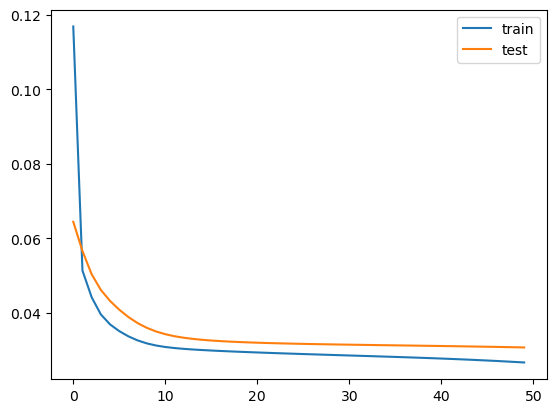

In [8]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()



In [9]:
# make a prediction
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
r2 = r2_score(test_y, yhat)
rmse, r2

16/16 [==============================] - 0s 486us/step


(0.1751227282707589, 0.6131907684717626)

In [15]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: operands could not be broadcast together with shapes (503,12) (13,) (503,12) 